In [4]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set the style for the plots
plt.style.use('seaborn')
sns.set_context("notebook", font_scale=1.5)

# Specify the path to your run directory
run_dir = "/home/jakub/projects/double_descend/double_descent_torch/runs/run_20241006_215645"

# Function to load results
def load_results(k):
    results_path = os.path.join(run_dir, "results", f"resnet18k_{k}_results.pt")
    return torch.load(results_path)

# Load all results
k_values = range(1, 11)  # Adjust this range based on your actual k values
all_results = {k: load_results(k) for k in k_values}

# Create a DataFrame for easier plotting
data = []
for k, results in all_results.items():
    for epoch, (train_loss, train_acc, test_loss, test_acc) in enumerate(zip(
        results['train_loss'], results['train_acc'], 
        results['test_loss'], results['test_acc']
    )):
        data.append({
            'k': k,
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'test_loss': test_loss,
            'test_acc': test_acc
        })

df = pd.DataFrame(data)

# Plot training and test accuracy for all k values
plt.figure(figsize=(12, 8))
for k in k_values:
    plt.plot(df[df['k'] == k]['epoch'], df[df['k'] == k]['train_acc'], label=f'Train k={k}')
    plt.plot(df[df['k'] == k]['epoch'], df[df['k'] == k]['test_acc'], label=f'Test k={k}', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy for Different k Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot final test accuracy vs k
final_test_acc = [df[(df['k'] == k) & (df['epoch'] == df['epoch'].max())]['test_acc'].values[0] for k in k_values]
plt.figure(figsize=(10, 6))
plt.plot(k_values, final_test_acc, marker='o')
plt.xlabel('k')
plt.ylabel('Final Test Accuracy')
plt.title('Final Test Accuracy vs k')
plt.grid(True)
plt.show()

# Create heatmap of test accuracy
pivot_df = df.pivot(index='epoch', columns='k', values='test_acc')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap='viridis')
plt.xlabel('k')
plt.ylabel('Epoch')
plt.title('Test Accuracy Heatmap')
plt.show()

# Plot training curves for specific k values
k_to_plot = [1, 5, 10]  # Adjust these values as needed
plt.figure(figsize=(12, 8))
for k in k_to_plot:
    plt.plot(df[df['k'] == k]['epoch'], df[df['k'] == k]['train_loss'], label=f'Train Loss k={k}')
    plt.plot(df[df['k'] == k]['epoch'], df[df['k'] == k]['test_loss'], label=f'Test Loss k={k}', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss for Selected k Values')
plt.legend()
plt.show()

/tmp/ipykernel_3820339/526594669.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


FileNotFoundError: [Errno 2] No such file or directory: '/home/jakub/projects/double_descend/double_descent_torch/runs/run_20241006_215645/results/resnet18k_1_results.pt'

In [3]:
import matplotlib.colors as colors
import matplotlib.ticker as ticker

# Create heatmap of test accuracy
pivot_df = df.pivot(index='epoch', columns='k', values='test_acc')
pivot_df = pivot_df.iloc[::-1]  # Reverse the order of rows

plt.figure(figsize=(15, 8))
ax = plt.gca()

# Create the heatmap
im = ax.imshow(pivot_df, cmap='inferno', norm=colors.LogNorm(vmin=pivot_df.min().min(), vmax=pivot_df.max().max()),
               aspect='auto', interpolation='none')

# Y-axis (Epochs)
max_epochs = pivot_df.index.max()
base = 1.1  # You can adjust this value
eps = np.unique(np.array(base**np.arange(0, np.log(max_epochs)/np.log(base)), dtype=int))
y_ticks = np.searchsorted(pivot_df.index, eps)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f'{e+1}' for e in eps], fontsize=12)
ax.set_ylabel('Epochs', fontsize=16)

# X-axis (k values)
x_ticks = range(0, len(pivot_df.columns), 2)  # Show every other k value
ax.set_xticks(x_ticks)
ax.set_xticklabels([str(k) for k in pivot_df.columns[x_ticks]], fontsize=12)
ax.set_xlabel('ResNet18 Width Parameter', fontsize=16)

# Colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)

# Title
plt.title('Test Accuracy Heatmap', fontsize=18)

plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

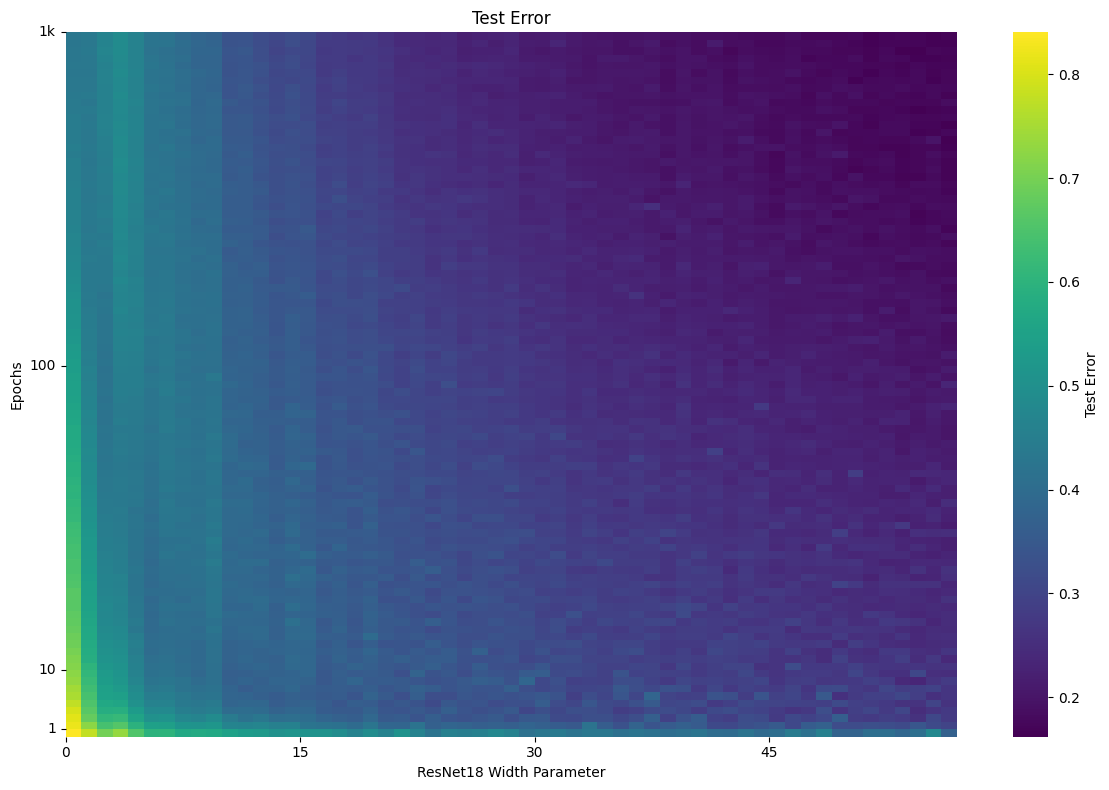

In [33]:
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Specify the path to your run directory
run_dir = "/home/jakub/projects/double_descend/double_descent_torch/runs/run_20241011_115420/results"

# Function to load results
def load_results(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Load all results
all_results = []
for filename in os.listdir(run_dir):
    if filename.startswith("resnet18k_") and filename.endswith("_results.json"):
        file_path = os.path.join(run_dir, filename)
        k = int(filename.split("_")[1])  # Extract k value from filename
        results = load_results(file_path)
        for result in results:
            result['k'] = k  # Add k to each result dictionary
        all_results.extend(results)

# Create a DataFrame
df = pd.DataFrame(all_results)

# Pivot the DataFrame for the heatmap
pivot_df = 1 - df.pivot(index='epoch', columns='k', values='test_acc')

# Create a custom y-axis
linear_epochs = range(1, 11)
log_epochs = np.logspace(np.log10(10), np.log10(1000), num=90).astype(int)
custom_epochs = np.unique(np.concatenate([linear_epochs, log_epochs]))

# Interpolate the data to match our custom epochs
interpolated_df = pivot_df.reindex(custom_epochs).interpolate(method='linear')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the heatmap
sns.heatmap(interpolated_df.iloc[::-1], cmap='viridis', ax=ax, cbar_kws={'label': 'Test Error'})

# Customize the y-axis
y_ticks = [len(custom_epochs)-1, 
           len(custom_epochs) - np.searchsorted(custom_epochs, 10),
           len(custom_epochs) - np.searchsorted(custom_epochs, 100),
           0]
ax.set_yticks(y_ticks)
ax.set_yticklabels(['1', '10', '100', '1k'])

# Customize x-axis
ax.set_xticks(range(0, len(interpolated_df.columns), 15))
ax.set_xticklabels(range(0, len(interpolated_df.columns), 15))

# Customize labels and title
ax.set_xlabel('ResNet18 Width Parameter')
ax.set_ylabel('Epochs')
ax.set_title('Test Error')

plt.tight_layout()
plt.show()

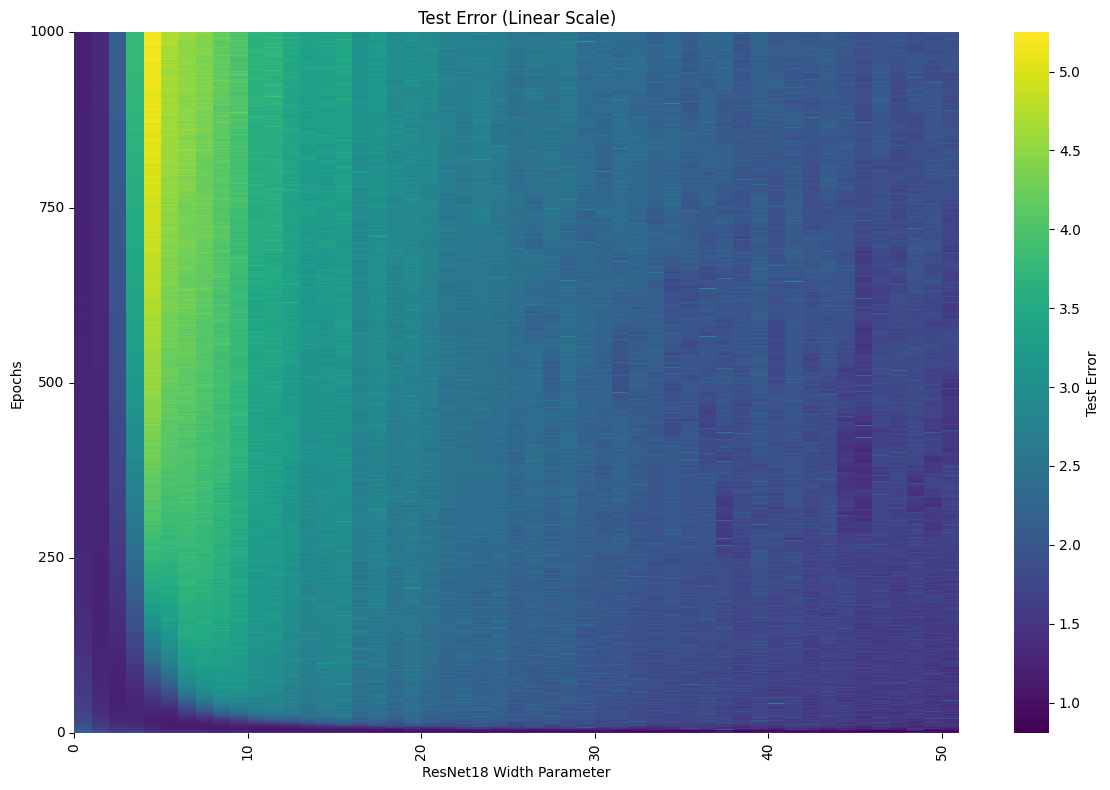

In [25]:
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Specify the path to your run directory
run_dir = "/home/jakub/projects/double_descend/double_descent_torch/runs/run_20241011_115420/results"

# Function to load results
def load_results(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Load all results
all_results = []
for filename in os.listdir(run_dir):
    if filename.startswith("resnet18k_") and filename.endswith("_results.json"):
        file_path = os.path.join(run_dir, filename)
        k = int(filename.split("_")[1])  # Extract k value from filename
        results = load_results(file_path)
        for result in results:
            result['k'] = k  # Add k to each result dictionary
        all_results.extend(results)

# Create a DataFrame
df = pd.DataFrame(all_results)

# Pivot the DataFrame for the heatmap
pivot_df = df.pivot(index='epoch', columns='k', values='test_loss')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the heatmap
sns.heatmap(pivot_df.iloc[::-1], cmap='viridis', ax=ax, cbar_kws={'label': 'Test Error'})

# Customize x-axis
ax.set_xticks(range(0, len(pivot_df.columns), 10))
ax.set_xticklabels(range(0, len(pivot_df.columns), 10))

# Customize y-axis
max_epoch = pivot_df.index.max()
y_ticks = [0, max_epoch//4, max_epoch//2, 3*max_epoch//4, max_epoch]
ax.set_yticks([max_epoch - tick for tick in y_ticks])
ax.set_yticklabels(y_ticks)

# Customize labels and title
ax.set_xlabel('ResNet18 Width Parameter')
ax.set_ylabel('Epochs')
ax.set_title('Test Error (Linear Scale)')

plt.tight_layout()
plt.show()

In [ ]:
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Specify the paths to your run directories
run_dir1 = "/home/jakub/projects/double_descend/double_descent_torch/runs/run_20241020_015717/results"
run_dir2 = "/home/jakub/projects/double_descend/double_descent_torch/runs/run_20241011_115420/results"

# Function to load results
def load_results(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Function to load all results from a directory
def load_all_results(run_dir):
    all_results = []
    for filename in os.listdir(run_dir):
        if filename.startswith("resnet18k_") and filename.endswith("_results.json"):
            file_path = os.path.join(run_dir, filename)
            k = int(filename.split("_")[1])  # Extract k value from filename
            results = load_results(file_path)
            for result in results:
                result['k'] = k  # Add k to each result dictionary
            all_results.extend(results)
    return pd.DataFrame(all_results)

# Load results from both directories
df1 = load_all_results(run_dir1)
df2 = load_all_results(run_dir2)

# Find common k values and epochs
common_k = sorted(set(df1['k']) & set(df2['k']))
common_epochs = sorted(set(df1['epoch']) & set(df2['epoch']))

# Filter dataframes to include only common k values and epochs
df1 = df1[(df1['k'].isin(common_k)) & (df1['epoch'].isin(common_epochs))]
df2 = df2[(df2['k'].isin(common_k)) & (df2['epoch'].isin(common_epochs))]

# Average the results
df_avg = pd.concat([df1, df2]).groupby(['epoch', 'k']).mean().reset_index()

# Pivot the DataFrame for the heatmap
pivot_df = 1 - df_avg.pivot(index='epoch', columns='k', values='test_acc')

# Create a custom y-axis
linear_epochs = range(1, 11)
log_epochs = np.logspace(np.log10(10), np.log10(pivot_df.index.max()), num=90).astype(int)
custom_epochs = np.unique(np.concatenate([linear_epochs, log_epochs]))

# Interpolate the data to match our custom epochs
interpolated_df = pivot_df.reindex(custom_epochs).interpolate(method='linear')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the heatmap
sns.heatmap(interpolated_df.iloc[::-1], cmap='viridis', ax=ax, cbar_kws={'label': 'Average Test Error'})

# Customize the y-axis
y_ticks = [len(custom_epochs)-1, 
           len(custom_epochs) - np.searchsorted(custom_epochs, 10),
           len(custom_epochs) - np.searchsorted(custom_epochs, 100),
           0]
ax.set_yticks(y_ticks)
ax.set_yticklabels(['1', '10', '100', f'{custom_epochs.max()}'])

# Customize x-axis
ax.set_xticks(range(0, len(interpolated_df.columns), 15))
ax.set_xticklabels(common_k[::15])

# Customize labels and title
ax.set_xlabel('ResNet18 Width Parameter')
ax.set_ylabel('Epochs')
ax.set_title('Average Test Error (Across Two Runs)')

plt.tight_layout()
plt.show()

# Upload to figshare

In [31]:
import os
import json
import hashlib
import requests
from requests.exceptions import HTTPError


# Constants
BASE_URL = 'https://api.figshare.com/v2/{endpoint}'
TOKEN = "a22aa5018cfec6677d3cce4aec48575ef51626a4234f3260651a1443fa018e83e642874680b366677610e87e744ad27be91ecb717574ce6eefb0f01d97c0e867"  # Replace with your API token
CHUNK_SIZE = 10485760  # about 10MB
FILE_PATH = "/home/jakub/projects/double_descend/double_descent_torch/runs.zip"  # Provide the full path to your file
TITLE = 'Uploaded through API'  # Set your article title

# Function to make API requests with error handling
def raw_issue_request(method, url, data=None, binary=False):
    headers = {'Authorization': 'token ' + TOKEN}
    if data is not None and not binary:
        data = json.dumps(data)
    response = requests.request(method, url, headers=headers, data=data)
    try:
        response.raise_for_status()
        try:
            data = json.loads(response.content)
        except ValueError:
            data = response.content
    except HTTPError as error:
        print(f'Caught an HTTPError: {error}')
        print('Body:\n', response.content)
        raise

    return data


# Wrapper function to interact with Figshare API
def issue_request(method, endpoint, *args, **kwargs):
    return raw_issue_request(method, BASE_URL.format(endpoint=endpoint), *args, **kwargs)


# List all articles
def list_articles():
    result = issue_request('GET', 'account/articles')
    print('Listing current articles:')
    if result:
        for item in result:
            print(f'  {item["url"]} - {item["title"]}')
    else:
        print('  No articles.')


# Create a new article
def create_article(title):
    data = {
        'title': title
    }
    result = issue_request('POST', 'account/articles', data=data)
    print('Created article:', result['location'], '\n')

    result = raw_issue_request('GET', result['location'])

    return result['id']


# List files in the article
def list_files_of_article(article_id):
    result = issue_request('GET', f'account/articles/{article_id}/files')
    print(f'Listing files for article {article_id}:')
    if result:
        for item in result:
            print(f'  {item["id"]} - {item["name"]}')
    else:
        print('  No files.')
    print()


# Get MD5 and size of the file for upload
def get_file_check_data(file_name):
    with open(file_name, 'rb') as fin:
        md5 = hashlib.md5()
        size = 0
        data = fin.read(CHUNK_SIZE)
        while data:
            size += len(data)
            md5.update(data)
            data = fin.read(CHUNK_SIZE)
        return md5.hexdigest(), size


# Initiate a new file upload to the article
def initiate_new_upload(article_id, file_name):
    endpoint = f'account/articles/{article_id}/files'

    md5, size = get_file_check_data(file_name)
    data = {'name': os.path.basename(file_name), 'md5': md5, 'size': size}

    result = issue_request('POST', endpoint, data=data)
    print('Initiated file upload:', result['location'], '\n')

    result = raw_issue_request('GET', result['location'])

    return result


# Complete the upload process after uploading all parts
def complete_upload(article_id, file_id):
    issue_request('POST', f'account/articles/{article_id}/files/{file_id}')


# Upload file in parts
def upload_parts(file_info):
    url = file_info['upload_url']
    result = raw_issue_request('GET', url)

    print('Uploading parts:')
    with open(FILE_PATH, 'rb') as fin:
        for part in result['parts']:
            upload_part(file_info, fin, part)


# Upload each part of the file
def upload_part(file_info, stream, part):
    udata = file_info.copy()
    udata.update(part)
    url = f'{file_info["upload_url"]}/{part["partNo"]}'

    stream.seek(part['startOffset'])
    data = stream.read(part['endOffset'] - part['startOffset'] + 1)

    raw_issue_request('PUT', url, data=data, binary=True)
    print(f'  Uploaded part {part["partNo"]} from {part["startOffset"]} to {part["endOffset"]}')


# Main function to handle the full upload process
def main():
    # List existing articles
    list_articles()

    # Create a new article
    article_id = create_article(TITLE)
    list_articles()  # Verify that the article is created
    list_files_of_article(article_id)

    # Initiate file upload and upload the file
    file_info = initiate_new_upload(article_id, FILE_PATH)

    # Upload the file in parts
    upload_parts(file_info)

    # Complete the upload process
    complete_upload(article_id, file_info['id'])
    list_files_of_article(article_id)


# Run the upload script
if __name__ == '__main__':
    main()


Listing current articles:
  https://api.figshare.com/v2/account/articles/27226656 - My Private Dataset
  https://api.figshare.com/v2/account/articles/27226641 - My Private Dataset
  https://api.figshare.com/v2/account/articles/27226629 - My Private Dataset
  https://api.figshare.com/v2/account/articles/27226614 - My Private Dataset
  https://api.figshare.com/v2/account/articles/27226560 - My Private Dataset
  https://api.figshare.com/v2/account/articles/27226557 - My Private Dataset
  https://api.figshare.com/v2/account/articles/27226536 - My Private Dataset
  https://api.figshare.com/v2/account/articles/27226515 - My Private Dataset
  https://api.figshare.com/v2/account/articles/27226503 - My Private Dataset
  https://api.figshare.com/v2/account/articles/21984989 - LIBS spectra: Fe-Co certified sample set
Created article: https://api.figshare.com/v2/account/articles/27226731 

Listing current articles:
  https://api.figshare.com/v2/account/articles/27226731 - Uploaded through API
  ht